# Argonne National Laboratory (ATMOS) Current Conditions

In [1]:
from IPython.display import IFrame
import pandas as pd
import sage_data_client
import holoviews as hv
import hvplot.pandas
from metpy.units import units
import metpy.calc as mpcalc
from bokeh.models import DatetimeTickFormatter
import sage_data_client

hv.extension("bokeh")

def apply_formatter(plot, element):
    plot.handles['xaxis'].formatter = DatetimeTickFormatter(hours='%m/%d/%Y \n %l:%M %p',
                                                            minutes='%m/%d/%Y \n %l:%M %p',
                                                            hourmin='%m/%d/%Y \n %l:%M %p',
                                                            days='%m/%d/%Y \n %l:%M %p',
                                                            months='%m/%d/%Y \n %l:%M %p')

def add_local_time(df):
    df["Local_Time"] = pd.to_datetime(df.index,unit='s', utc=True)\
                          .map(lambda x: x.tz_convert('America/Chicago'))
    return df
import warnings
warnings.filterwarnings('ignore')

## Temperature and Dewpoint

In [3]:
wxt_df = sage_data_client.query(
    start="-12h", 
    filter={
        "vsn": "W0A4",
        "name": "wxt.env.temp|wxt.env.humidity"
    }
).set_index("timestamp")

temp_df = wxt_df.loc[wxt_df.name == "wxt.env.temp"]
hum_df = wxt_df.loc[wxt_df.name == "wxt.env.humidity"]

min_df = temp_df[["value"]].resample("1min").mean()
min_df["rh"] = hum_df[["value"]].resample("1min").mean()

min_df["tmpf"] = (min_df.value.values * units.degC).to("degF").m
min_df["dwpf"] = mpcalc.dewpoint_from_relative_humidity(min_df.tmpf.values * units.degF,
                                       min_df.rh.values * units.percent).to("degF").m

min_df = add_local_time(min_df)

temp_plot = min_df.hvplot(x='Local_Time',
                          y='tmpf',
                          color = "r",
                          label="Temperature [degF]"
                         )
dewp_plot = min_df.hvplot(x='Local_Time',
                          y='dwpf',
                          color="g",
                          title="Current Weather at Argonne National Laboratory (ATMOS)",
                          label="Dewpoint [degF]",
                          ylabel="Temperature | Dewpoint \n [degF]",
                          xlabel="Local Time (Central/US)")

(temp_plot * dewp_plot).opts(hooks=[apply_formatter], legend_position='right')

:Overlay
   .Curve.Temperature_left_square_bracket_degF_right_square_bracket :Curve   [Local_Time]   (tmpf)
   .Curve.Dewpoint_left_square_bracket_degF_right_square_bracket    :Curve   [Local_Time]   (dwpf)

## Air Quality

In [4]:
df = sage_data_client.query(
    start="-12h", 
    filter={
        "vsn": "W0A4",
        "name": "aqt.particle.pm2.5"
    }
).set_index("timestamp")

df = add_local_time(df)[["value", "Local_Time"]].resample("5min").mean()

df.hvplot(label='PM 2.5 Values at Argonne National Laboratory (ATMOS)',
          x='Local_Time',
          y='value',
          ylabel='PM 2.5 \n [microgram per cubic meter]',
          xlabel="Local Time (Central/US)").opts(hooks=[apply_formatter])

:Curve   [Local_Time]   (value)

## Cloud Base Height and Vertical Profile
Measurements from a ceilometer which shows the cloud base height and vertical profile above the site.

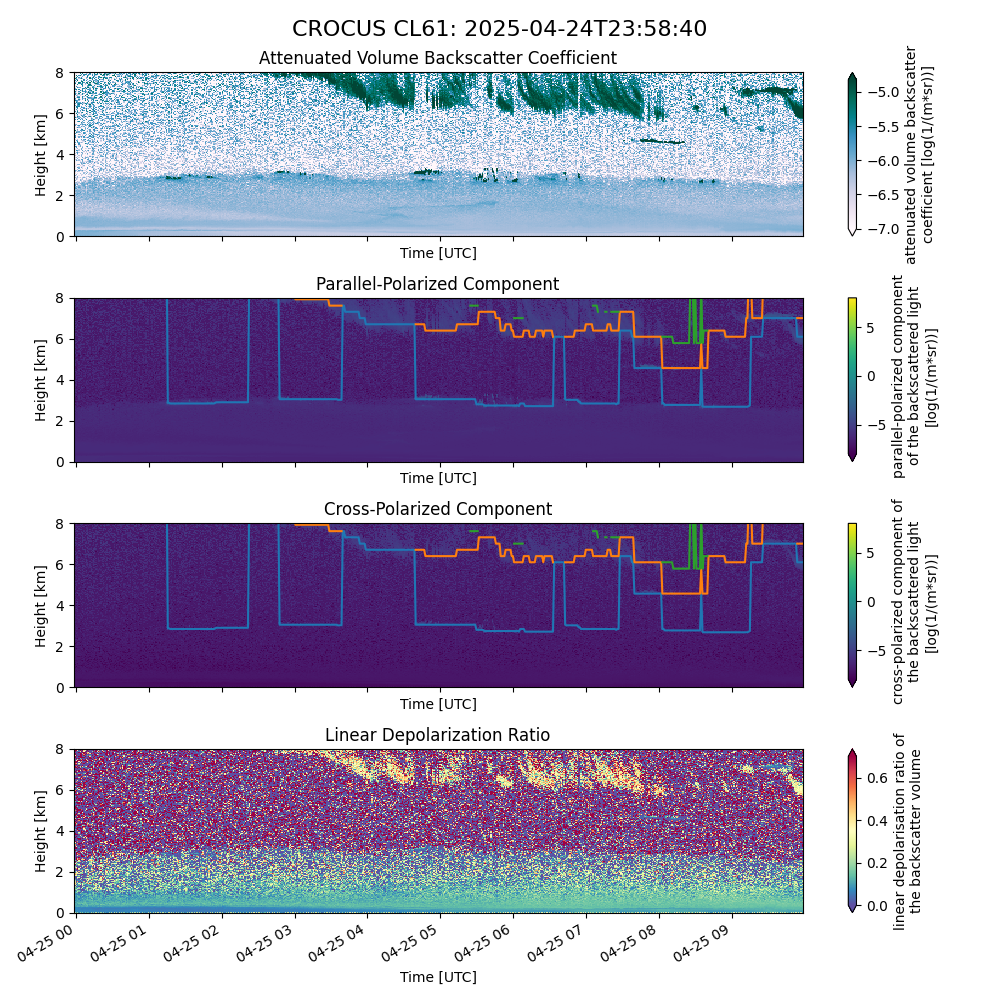

In [2]:
import os
import requests
from IPython.display import Image
import sage_data_client

def readtofile(uurl, fname, input_args):
    """
    Given a URL, read data to local files

    Parameters
    ----------
    uurl : str
        HTML consisting of file to download from Beehive
    fname : str
        Path for local location to store data into
    input_args : dictionary
        Input Argument dictionary
    """
    r = requests.get(uurl,
                     auth=(input_args["user"], input_args["password"]),
                     timeout=25)
    if r.status_code == 200:
        with open(fname, 'wb') as out:
            for bits in r.iter_content():
                out.write(bits)
    elif r.status_code == 404:
        print("404 Error: File Not Found")
    else:
        print("HTML Request Status - ", r.status_code)
    return True


df = sage_data_client.query(
    start="-6h",
    filter={
        "plugin": "registry.sagecontinuum.org/bhupendraraut/cl61-plot:0.25.*",
        "vsn": "W09A"
    }
)


# Grab the most recent image
uurl = df.value.values[-1]
input_args = {
    "user": os.getenv("WAGGLE_USERNAME"),
    "password": os.getenv("WAGGLE_PASSWORD")
}
outpath = os.getcwd() + "/current-atmos-cl61.png"
readtofile(uurl, outpath, input_args)


Image(filename=outpath, width=600)

## Location
Observations from the Argonne National Laboratory, at the Argonne Testbed for Multiscale Observational Science (ATMOS).

<div>
<img src="../../images/atmos-node.jpg" width="500"/>
</div>

In [5]:
IFrame("https://www.google.com/maps/embed?pb=!1m17!1m12!1m3!1d1127.9916583864983!2d-87.99606298327078!3d41.70155707281444!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m2!1m1!2zNDHCsDQyJzA1LjciTiA4N8KwNTknNDIuNSJX!5e1!3m2!1sen!2sus!4v1745338004627!5m2!1sen!2sus", width=700, height=350)